# Dynamic Cross-Correlation Matrix
---

### Workflow Steps
1. **Download structure and trajectory files** using the API.  
2. **Extract the XYZ coordinates of Cα atoms**.  
3. **Calculate the pairwise correlation** of the selected atoms.

---

For more information about this database, see our related work [*DynaRepo: The Repository of Macromolecular Conformational Dynamics*](https://doi.org/10.1101/2025.08.14.670260).

**Authors:**  
Omid Mokhtari, Emmanuelle Bignon, Hamed Khakzad, Yasaman Karami (Nancy, France)

**For correspondence:** yasaman.karami@inria.fr

---
    
#### Import Required Libraries

In [1]:
import json, urllib
from os.path import exists
import mdtraj as md
import numpy as np
import glob
import os
import plotly.graph_objs as go

In [2]:
API_BASE_URL = "http://inria.mddbr.eu/api/rest/current"

In [3]:
def query_api (url : str) -> dict:
    parsed_url = url.replace(" ", "%20")
    with urllib.request.urlopen(parsed_url) as response:
        return json.loads(response.read().decode("utf-8"))
def download_file_api (url : str, filename : str):
    parsed_url = url.replace(" ", "%20")
    urllib.request.urlretrieve(url, filename)
def calculate_dccm(coords):
    """Calculate DCCM efficiently."""
    n_frames, n_atoms, _ = coords.shape
    coords_flat = coords.reshape(n_frames, -1)
    coords_centered = coords_flat - coords_flat.mean(axis=0)
    
    # Covariance matrix
    cov = np.dot(coords_centered.T, coords_centered) / (n_frames - 1)
    cov = cov.reshape(n_atoms, 3, n_atoms, 3).sum(axis=(1, 3))
    
    # Normalize to correlation
    std = np.sqrt(np.diag(cov))
    return cov / np.outer(std, std)

#### Download both structure and trajectory data

Change the project name

In [4]:
project_name = 'A00K6'

# Set the structure query URL for the API
specific_project_url = API_BASE_URL + f'/projects/{project_name}'
structure_query = specific_project_url + '/files/structure'
print('We query the API at ' + structure_query)

# Download the file with an arbitrary name
structure_filename = 'structure.pdb'
download_file_api(structure_query, structure_filename)
if exists(structure_filename):
    print('Structure file has been downloaded successfully')

# Set the structure query URL for the API
trajectory_query = specific_project_url + '/files/trajectory?format=xtc'
print('We query the API at ' + trajectory_query)

# Download the file with an arbitrary name
trajectory_filename = 'trajectory.xtc'
print('This may take a few seconds...', end='\r')
download_file_api(trajectory_query, trajectory_filename)
if exists(trajectory_filename):
    print('Trajectory file has been downloaded successfully')

We query the API at http://inria.mddbr.eu/api/rest/current/projects/A00K6/files/structure
Structure file has been downloaded successfully
We query the API at http://inria.mddbr.eu/api/rest/current/projects/A00K6/files/trajectory?format=xtc
Trajectory file has been downloaded successfully


### Coordinate extraction

In [5]:
# Load trajectory
traj = md.load(trajectory_filename, top=structure_filename)

# Get coordinates For C-alpha atoms only - shape [n_frames, n_atoms, 3]
ca_indices = traj.topology.select('name CA')
ca_coords = traj.xyz[:, ca_indices, :]

# Save as numpy array
#np.save('coordinates.npy', ca_coords)

### DCCM calculation

In [6]:
dccm = calculate_dccm(ca_coords)

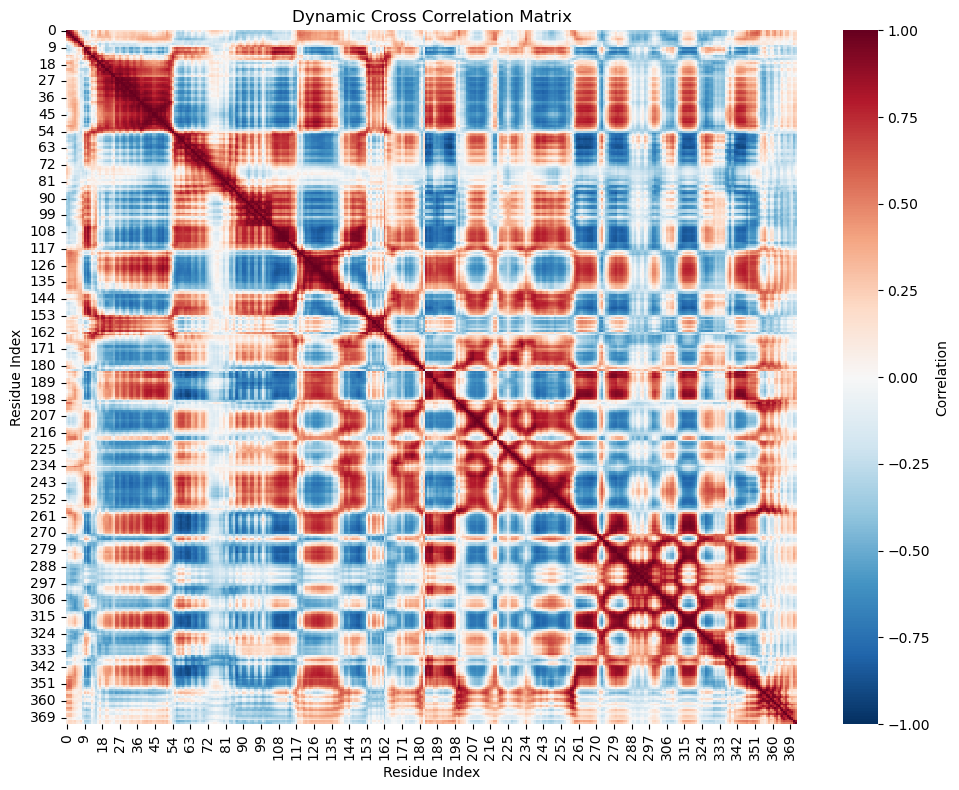

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(dccm, cmap='RdBu_r', center=0, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
plt.title('Dynamic Cross Correlation Matrix')
plt.xlabel('Residue Index')
plt.ylabel('Residue Index')
plt.tight_layout()
#plt.savefig('dccm.png', dpi=300)
plt.show()

# Curious or stuck? Drop me a line:

Omid.mokhtari@inria.fr